In [1]:
import os
import sys
sys.path.append("..")
import numpy as np
from py_helpers.general_helpers import *

# Define the paths to the results
labs = False
if labs:
    results_path = "/media/hsa22/Expansion/WBM/results"
else:
    results_path = "D:\\WBM\\results"

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

# Generate a custom color palette
color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.1, light=0.9)
beige_palette = sns.light_palette(color_palette[4], n_colors=10)

# Extract specific colors
pinkish = color_palette[5]
purpleish = color_palette[7]
beige_color = beige_palette[1]

# Extract old stem plot colors
pinkish_stem = color_palette[2]
purpleish_stem = color_palette[6]

# Print the purpleish color in hex
print(rgb2hex(pinkish))

#704071


## **Load the Data**

In [40]:
# Define the neural models
neural_models = ["kuramoto"]

# Define the modes
modes = ["tracer"]

# Define the symmetric and asymmetric modes
symmetric_modes = ["asymmetric"]

In [41]:
# Grab all the txt and csv files for the correlation
txt_files = glob_files(results_path, "txt")
csv_files = glob_files(results_path, "csv")

# Assert that the number of txt and csv files are the same
assert len(txt_files) == len(csv_files), "Number of txt and csv files are not the same!"

# Separate text files into correlation and order
corr_txt_files = [file for file in txt_files if "corr" in file]
order_txt_files = [file for file in txt_files if "order" in file]

# Separate csv files into sim_FC and bold
sim_FC_csv_files = [file for file in csv_files if "sim_FC" in file]
bold_csv_files = [file for file in csv_files if "bold" in file]

print("Number of correlation text files: {}".format(len(corr_txt_files)))
print("Number of order text files: {}".format(len(order_txt_files)))
print("Number of sim_FC csv files: {}".format(len(sim_FC_csv_files)))
print("Number of bold csv files: {}".format(len(bold_csv_files)))

# Assert that the number of correlation, order, sim_FC and bold files are the same
assert len(corr_txt_files) == len(order_txt_files) == len(sim_FC_csv_files) == len(bold_csv_files), "Number of correlation, order, sim_FC and bold files are not the same!"

Number of correlation text files: 3072
Number of order text files: 3072
Number of sim_FC csv files: 3072
Number of bold csv files: 3072


In [45]:
import os
import numpy as np

def organize_files(corr_txt_files, order_txt_files, sim_FC_csv_files, bold_csv_files, name="model"):
    """Organizes provided files into a structured dictionary."""

    # Initialize the dictionary to store the organized files
    organized_files = {}

    # Loop through the correlation text files
    for file in corr_txt_files:
        # Filter by the provided name (e.g., "model")
        if name in file:
            # Identify if it's symmetric or not from the directory structure
            symmetric = file.split(os.sep)[-3]

            # Construct paths to the corresponding files
            base_dir = os.path.dirname(file)
            corresponding_sim_FC_path = os.path.join(base_dir, "sim_FC.csv")
            corresponding_bold_path = os.path.join(base_dir, "bold_filtered.csv")
            corresponding_order_path = os.path.join(base_dir, "order_data.txt")

            # Check if all the corresponding paths exist
            if (corresponding_sim_FC_path in sim_FC_csv_files and 
                corresponding_bold_path in bold_csv_files and 
                corresponding_order_path in order_txt_files):
                
                data_dict = {
                    "corr_txt_path": file,
                    "order_txt_path": corresponding_order_path,
                    "sim_FC_csv_path": corresponding_sim_FC_path,
                    "bold_csv_path": corresponding_bold_path,
                    "correlation": np.loadtxt(file),
                    "order": np.loadtxt(corresponding_order_path),
                    "sim_FC": np.genfromtxt(corresponding_sim_FC_path, delimiter=","),
                    # "bold": np.genfromtxt(corresponding_bold_path, delimiter=",")
                }

                # Store the data dictionary under the symmetric/asymmetric key
                organized_files.setdefault(symmetric, []).append(data_dict)

    return organized_files

In [47]:
# Create dictionary that will store the files
neural_model_dict = {}

# Create a dictionary of the different models and their TXT and CSV files
for neural_model in neural_models:

    # Get the wilson and kuramoto files individually
    neural_model_corr_txt_files = [file for file in corr_txt_files if neural_model in file]
    neural_model_order_txt_files = [file for file in order_txt_files if neural_model in file]
    neural_model_sim_FC_csv_files = [file for file in sim_FC_csv_files if neural_model in file]
    neural_model_bold_csv_files = [file for file in bold_csv_files if neural_model in file]

    for mode in modes:

        print("Current mode: {}".format(mode))

        # Define dictionary for model, traditional, and tracer files
        neural_files = organize_files(neural_model_corr_txt_files, 
                                      neural_model_order_txt_files, 
                                      neural_model_sim_FC_csv_files, 
                                      neural_model_bold_csv_files, 
                                      name=mode)
                
        # Append the neural_files to the neural_model_dict
        if neural_model in neural_model_dict:
            neural_model_dict[neural_model][mode] = neural_files
        else:
            neural_model_dict[neural_model] = {mode: neural_files}

# Print the max correlation for each neural model
for neural_model in neural_model_dict:
    print("-"*50)
    print("Neural model: {}".format(neural_model))
    for mode in neural_model_dict[neural_model]:
        for idx, symmetric in enumerate(neural_model_dict[neural_model][mode]):

            print("Max {}, {} correlation: {}".format(mode, symmetric, np.max([np.max(data_dict["correlation"]) for data_dict in neural_model_dict[neural_model][mode][symmetric]])))


Number of kuramoto correlation text files: 3072
Current mode: tracer
--------------------------------------------------
Neural model: kuramoto
Max tracer, asymmetric correlation: 0.35769806


## **Organize Data into Pandas Dataframe**

In [48]:
import pandas as pd
import re

# Function to organize data into pandas dataframe
def extract_data_and_create_df(entries):
    """Utility function to extract data and create a dataframe."""
    df_rows = []
    for entry in entries:
        # Extract the coupling and delay values using regex
        match = re.search(r"Coupling (\d+\.\d+), Delay(\d+\.\d+)", entry["corr_txt_path"])
        
        if match:
            coupling, delay = float(match.group(1)), float(match.group(2))
            df_rows.append((coupling, delay, entry["correlation"], entry["order"][0], entry["order"][1]))

    return pd.DataFrame(df_rows, columns=["Coupling", "Delay", "Correlation", "Order Mean", "Order Std"])

def create_dataframes_for_models(neural_model_dict):
    
    # Initialize empty dictionary for the output
    output_dict = {}

    for neural_model in neural_models:

        # Initialize empty dictionary for the mode
        output_dict[neural_model] = {}

        for mode in modes:

            # Initialize empty dictionary for the symmetry
            output_dict[neural_model][mode] = {}

            for symm in symmetric_modes:
                entries = neural_model_dict[neural_model][mode][symm]
                output_dict[neural_model][mode][symm] = extract_data_and_create_df(entries)

    return output_dict

In [50]:
# Create dataframes for the models
dataframes = create_dataframes_for_models(neural_model_dict)
print(dataframes["kuramoto"]["tracer"]["asymmetric"].head())

   Coupling  Delay  Correlation  Order Mean  Order Std
0       0.0    0.0  -0.02490041    0.098519   0.013174
1       0.0    1.0  -0.02490041    0.098519   0.013174
2       0.0    2.0  -0.02490041    0.098519   0.013174
3       0.0    3.0  -0.02490041    0.098519   0.013174
4       0.0    4.0  -0.02490041    0.098519   0.013174


## **Plot the Data**

#### Bayesian Optimization

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap

%matplotlib widget

def gradient_stem(ax, x, y, z, bottom, color_start, color_end):
    """
    Create a stem plot with gradient color effect.
    :param ax: Axis to plot on
    :param x, y, z: Data for stems
    :param bottom: Bottom of stems
    :param colors: List of color for gradient
    """
    segments = len(z)
    for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
        z_points = np.linspace(bottom, zi, segments)
        colors = [((zi - v) / (zi - bottom) * np.array(color_start) + (v - bottom) / (zi - bottom) * np.array(color_end)) for v in z_points]
        for j in range(1, segments):
            ax.plot([xi, xi], [yi, yi], [z_points[j-1], z_points[j]], color=colors[j])
            
        # Here we add the circle top at the end of each stem
        ax.scatter(xi, yi, zi, c=[tuple(color_end)], s=20)  # You can adjust `s` for size

def plot_bayesOpt_results(df, title, xlabel, ylabel, zlabel):
    # Extracting data from dataframe
    coupling = df['Coupling'].values
    delay = df['Delay'].values
    correlation = df['Correlation'].values

    # Generate a custom color palette
    color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.1, light=0.9)
    beige_palette = sns.light_palette(color_palette[4], n_colors=10)
    
    # Extract specific colors
    pinkish = color_palette[5]
    purpleish = color_palette[7]
    beige_color = beige_palette[1]

    # Extract old stem plot colors
    pinkish_stem = color_palette[2]
    purpleish_stem = color_palette[6]

    # Create a custom colormap using these colors
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom", 
        [beige_color, pinkish, purpleish]
    )

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)
    
    ax1 = ax[0]
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    gradient_stem(ax1, coupling, delay, correlation, correlation.min(), pinkish_stem, purpleish_stem)
    ax1.view_init(elev=10, azim=-110)
    
    # Set labels for ax1
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_zlabel(zlabel, labelpad=7)

    # Add a title
    ax1.set_title("Correlation vs. (Coupling, Delay)", fontsize=15)

    # Calculate KDE for ax2
    values = np.vstack([df['Coupling'], df['Delay']])
    kernel = gaussian_kde(values)

    x, y = np.mgrid[df['Coupling'].min():df['Coupling'].max():100j, df['Delay'].min():df['Delay'].max():100j]
    positions = np.vstack([x.ravel(), y.ravel()])
    z = np.reshape(kernel(positions).T, x.shape)
    
    ax2 = ax[1]
    # Filled contour
    c = ax2.contourf(x, y, z, levels=12, cmap=custom_cmap)

    # Contour lines with labels
    cs = ax2.contour(x, y, z, levels=12, colors='black')
    ax2.clabel(cs, inline=True, fontsize=10, fmt='%1.2f')
    
    fig.colorbar(c, ax=ax2, shrink=0.5, aspect=5)

    # To zoom in/out adjust the box dimensions (you can modify these values for the desired zoom level)
    ax1.auto_scale_xyz([df['Coupling'].min(), df['Coupling'].max()], 
                    [df['Delay'].min(), df['Delay'].max()], 
                    [correlation.min(), correlation.max()])
    
    # Remove outer ticks from ax1
    ax1.tick_params(axis='x', direction='in')
    ax1.tick_params(axis='y', direction='in')
    ax1.tick_params(axis='z', direction='in')

    # Set labels for ax
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)

    # Add a title
    ax2.set_title("Density Estimation of (Coupling, Delay) Choices", fontsize=15)

    # Set the title
    fig.suptitle("{title} - Optimization Results".format(title=title), fontsize=20)

    plt.show()

C:\Users\hana1\AppData\Local\Temp\ipykernel_19332\2320362363.py:14: RuntimeWarning: invalid value encountered in double_scalars
  colors = [((zi - v) / (zi - bottom) * np.array(color_start) + (v - bottom) / (zi - bottom) * np.array(color_end)) for v in z_points]


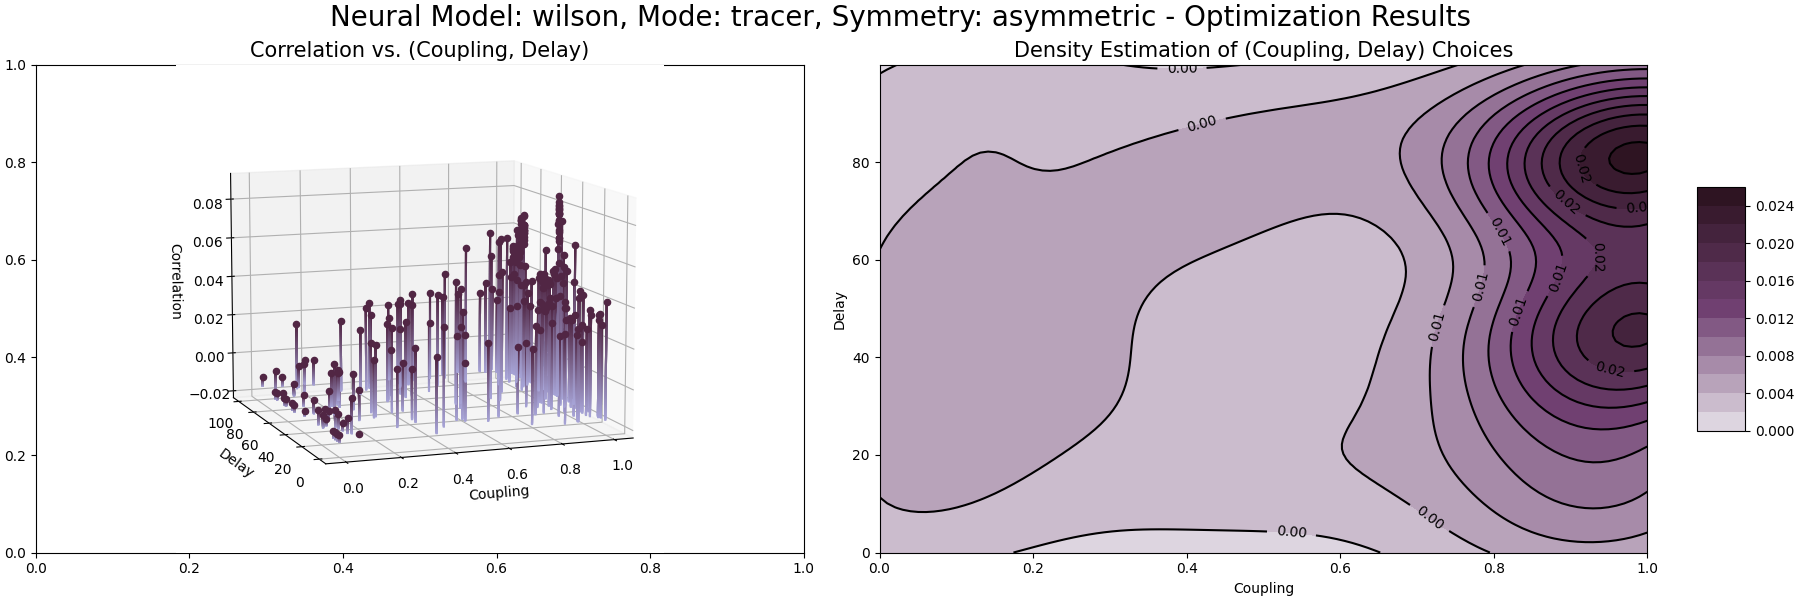

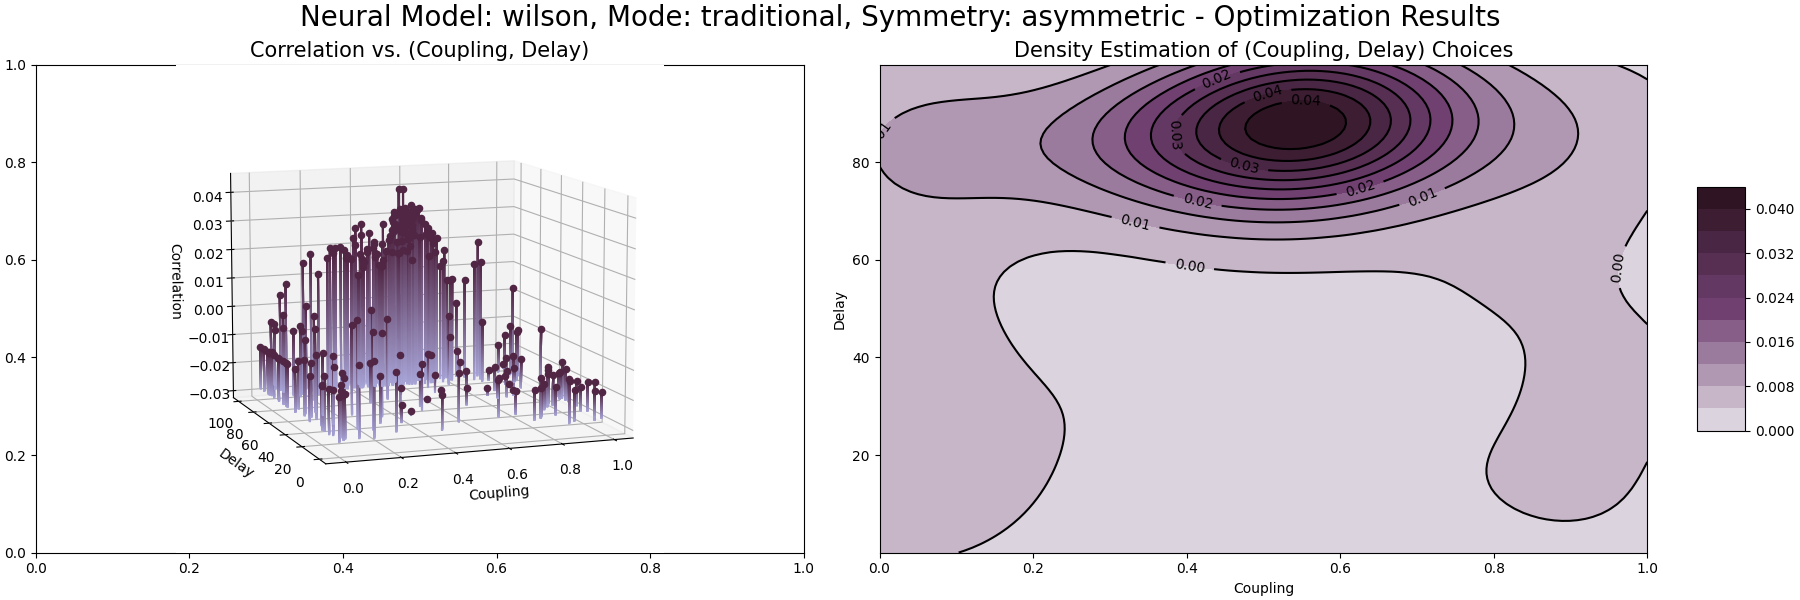

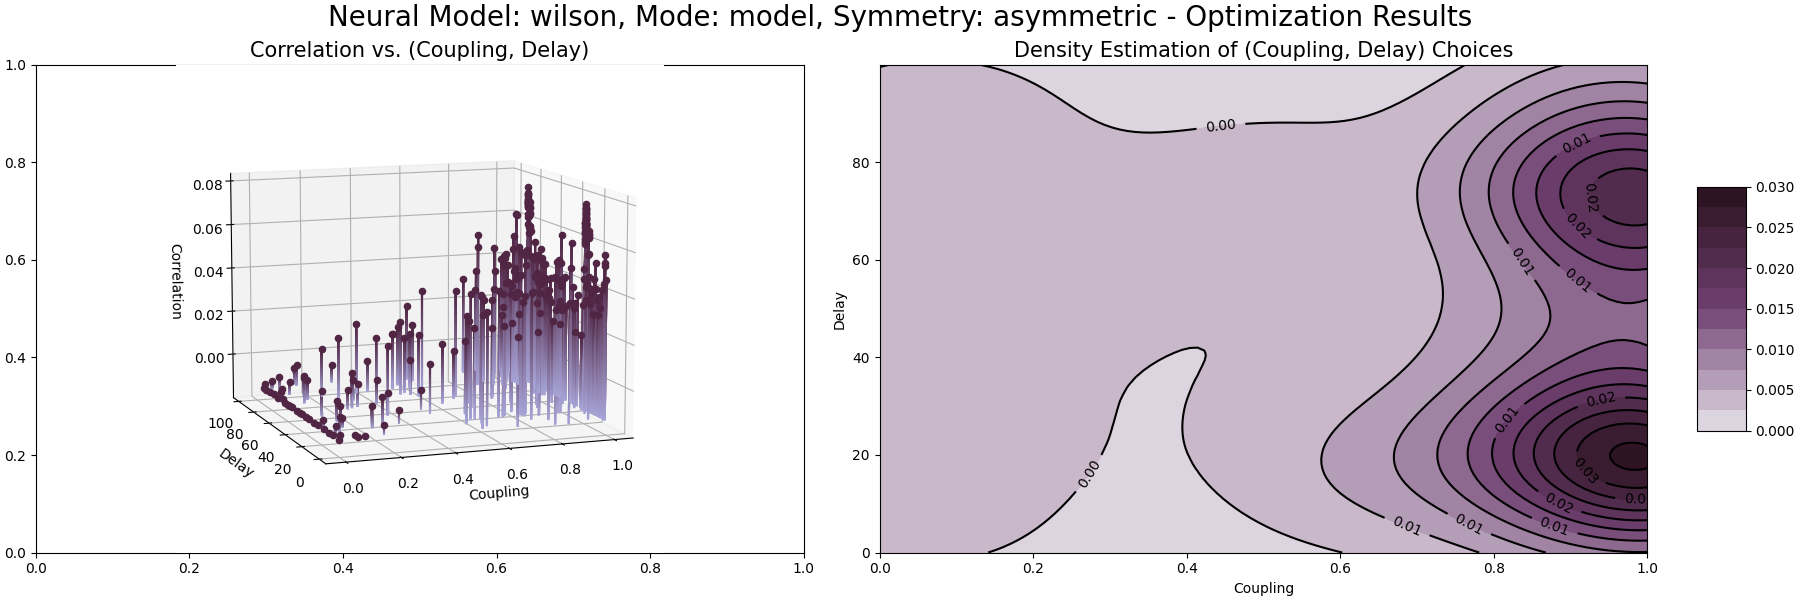

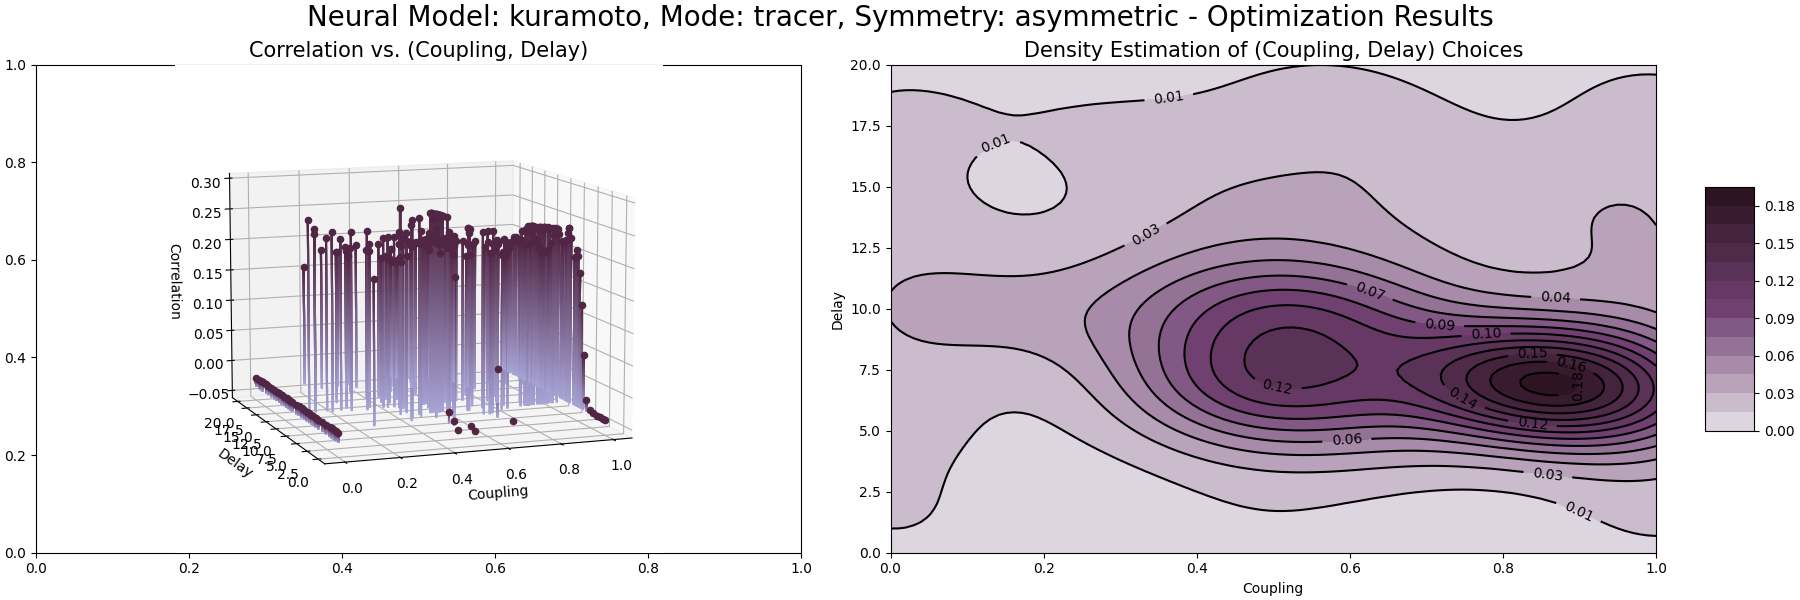

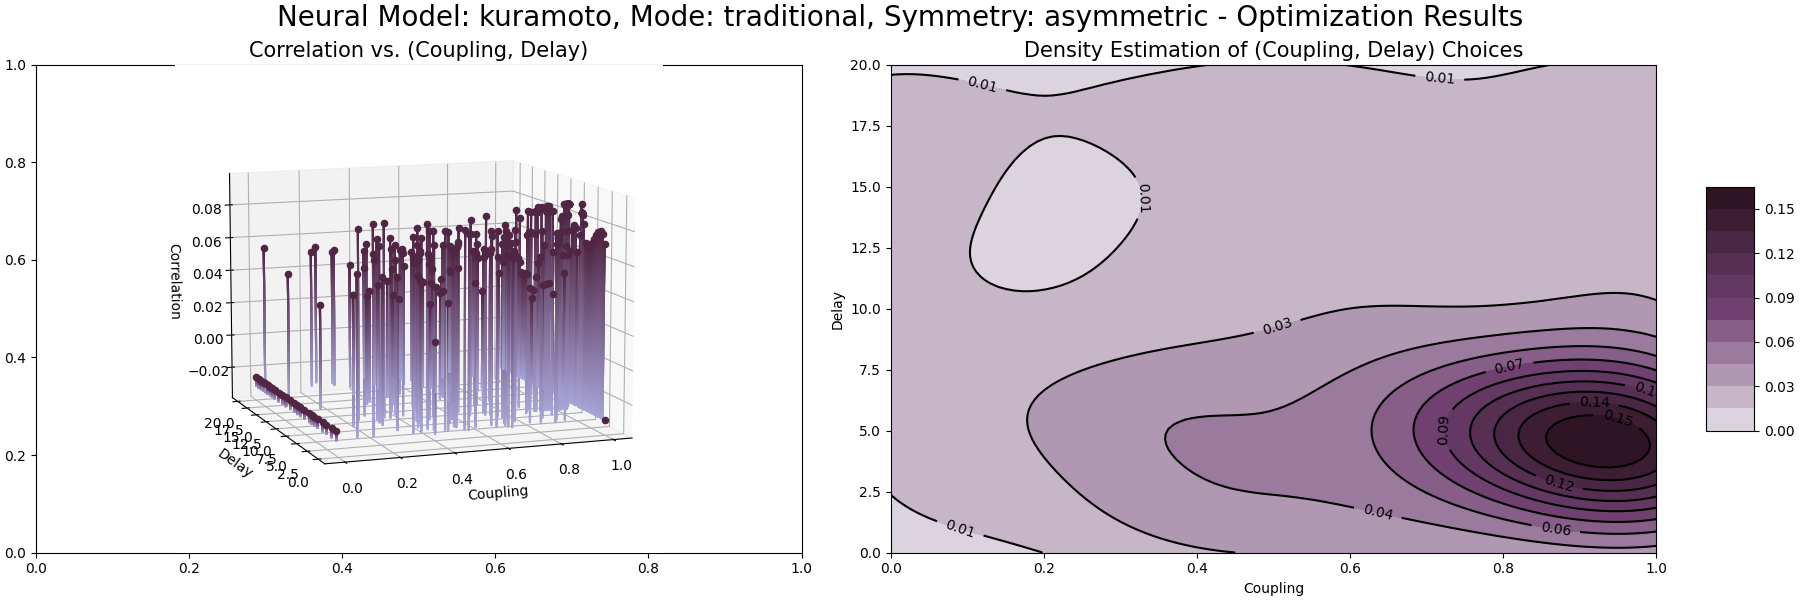

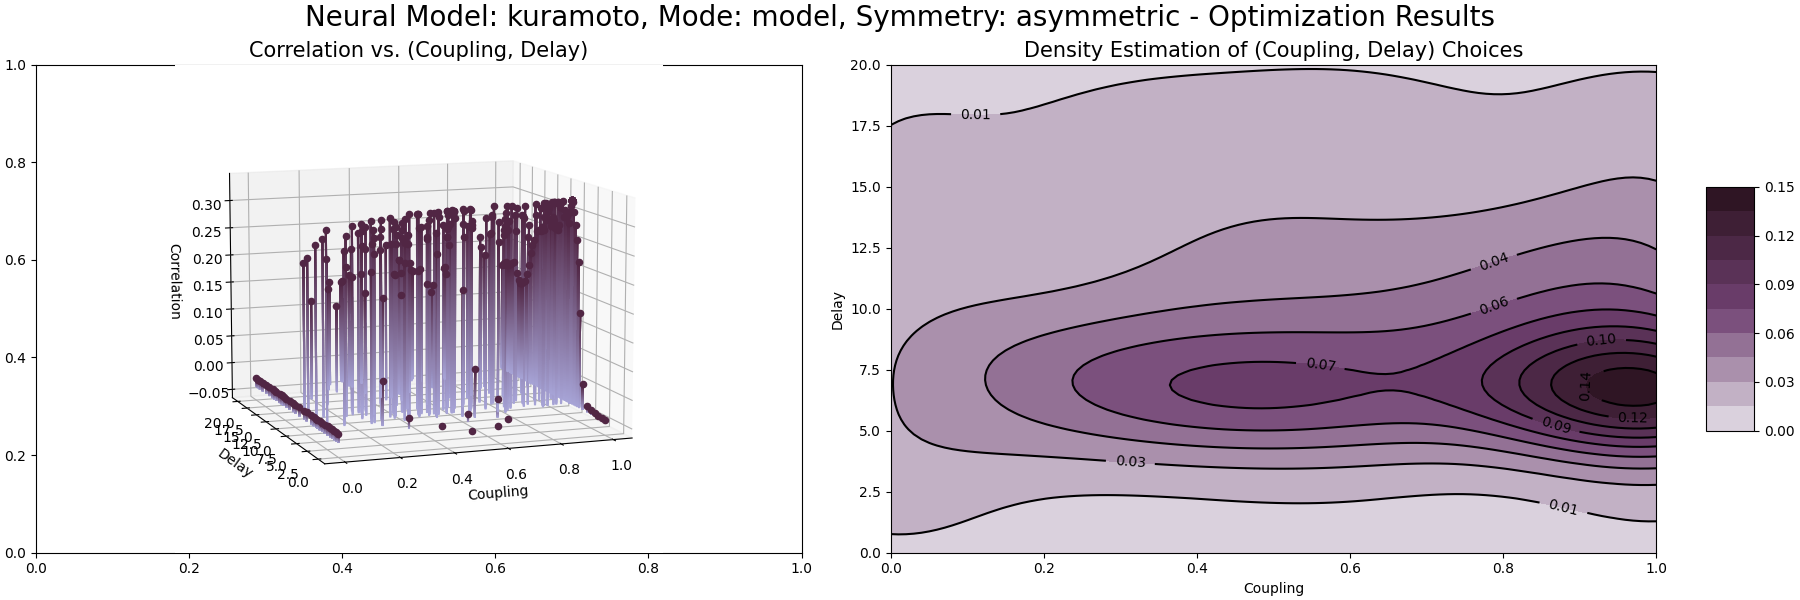

In [20]:
%matplotlib widget

# For each neural model, plot the results
for neural_model in neural_models:

    # For each mode, plot the results
    for mode in modes:

        # For each symmetry, plot the results
        for symm in symmetric_modes:

            # Extract the dataframe
            df = dataframes[neural_model][mode][symm]

            # Plot the results
            plot_bayesOpt_results(df, 
                                  title="Neural Model: {neural_model}, Mode: {mode}, Symmetry: {symm}".format(neural_model=neural_model, mode=mode, symm=symm), 
                                  xlabel="Coupling", 
                                  ylabel="Delay", 
                                  zlabel="Correlation")

#### Grid Search

## **Plotting BOLD signal**

In [26]:
if labs:
    bold_path = "/media/hsa22/Expansion/MBM_fmri/sub-NIHm32/ses-01/fmri_slices/sub-NIHm32_ses-01_task-rest_run-LR-2/processed_BOLD"
else:
    bold_path = "D:\\MBM_fmri\\sub-NIHm32\\ses-01\\fmri_slices\\sub-NIHm32_ses-01_task-rest_run-LR-2\\processed_BOLD"

# Grab all npy files and filter for ones with bold
npy_files = glob_files(bold_path, "npy")
bold_files = [file for file in npy_files if "BOLD" in file.split(os.sep)[-1].split("_")[1]]

# Filter for MBM files
MBM_bold_files = [file for file in bold_files if "MBM" in file.split(os.sep)[-1].split("_")[0]]

print("Number of bold files: {}".format(len(MBM_bold_files)))

Number of bold files: 1


In [ ]:
# Define the BOLD plotting function
def plot_BOLD(bold, title, xlabel, ylabel, zlabel):

    pass

In [ ]:
# For each neural model, plot the results
for neural_model in neural_models:

    # For each mode, plot the results
    for mode in modes:

        # For each symmetry, plot the results
        for symm in symmetric_modes:

            # Extract the dataframe
            df = dataframes[neural_model][mode][symm]

            # Plot the results
            plot_BOLD(df, 
                    title="Neural Model: {neural_model}, Mode: {mode}, Symmetry: {symm}".format(neural_model=neural_model, mode=mode, symm=symm), 
                    xlabel="Coupling", 
                    ylabel="Delay", 
                    zlabel="Correlation")